# ModelList (Multi-Output) QEP Regression

## Introduction

This notebook demonstrates how to wrap uncorrelated QEP models into a convenient Multi-Output QEP model using a ModelList. 

Unlike in the Multitask case, this do not model correlations between outcomes, but treats outcomes independently. This is equivalent to setting up a separate QEP for each outcome, but can be much more convenient to handle, in particular it does not require manually looping over models when fitting or predicting.

This type of model is useful if 
- when the number of training / test points is different for the different outcomes
- using different covariance modules and / or likelihoods for each outcome

For block designs (i.e. when the above points do not apply), you should instead use a batch mode GP as described in the [batch uncorrelated multioutput example](./Batch_Uncorrelated_Multioutput_QEP.ipynb). This will be much faster because it uses additional parallelism.

In [1]:
import math
import torch
import qpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up training data

In the next cell, we set up the training data for this example. We'll be using a different number of training examples for the different QEPs.

In [2]:
train_x1 = torch.linspace(0, 0.95, 50) + 0.05 * torch.rand(50)
train_x2 = torch.linspace(0, 0.95, 25) + 0.05 * torch.rand(25)

train_y1 = torch.sin(train_x1 * (2 * math.pi)) + 0.2 * torch.randn_like(train_x1)
train_y2 = torch.cos(train_x2 * (2 * math.pi)) + 0.2 * torch.randn_like(train_x2)

## Set up the sub-models

Each individual model uses the `ExactQEP` model from the [simple regression example](../01_Exact_QEPs/Simple_QEP_Regression.ipynb).

In [3]:
POWER = 1.0
class ExactQEPModel(qpytorch.models.ExactQEP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.power = torch.tensor(POWER)
        self.mean_module = qpytorch.means.ConstantMean()
        self.covar_module = qpytorch.kernels.ScaleKernel(qpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)
    

likelihood1 = qpytorch.likelihoods.QExponentialLikelihood(power=torch.tensor(POWER))
model1 = ExactQEPModel(train_x1, train_y1, likelihood1)

likelihood2 = qpytorch.likelihoods.QExponentialLikelihood(power=torch.tensor(POWER))
model2 = ExactQEPModel(train_x2, train_y2, likelihood2)

We now collect the submodels in an `UncorrelatedMultiOutputQEP`, and the respective likelihoods in a `MultiOutputLikelihood`. These are container modules that make it easy to work with multiple outputs. In particular, they will take in and return lists of inputs / outputs and delegate the data to / from the appropriate sub-model (it is important that the order of the inputs / outputs corresponds to the order of models with which the containers were instantiated).

In [4]:
model = qpytorch.models.UncorrelatedModelList(model1, model2)
likelihood = qpytorch.likelihoods.LikelihoodList(model1.likelihood, model2.likelihood)

### Set up overall Marginal Log Likelihood

Assuming independence, the MLL for the container model is simply the sum of the MLLs for the individual models. `SumMarginalLogLikelihood` is a convenient container for this (by default it uses an `ExactMarginalLogLikelihood` for each submodel)

In [5]:
from qpytorch.mlls import SumMarginalLogLikelihood

mll = SumMarginalLogLikelihood(likelihood, model)

### Train the model hyperparameters

With the containers in place, the models can be trained in a single loop on the container (note that this means that optimization is performed jointly, which can be an issue if the individual submodels require training via very different step sizes).

In [6]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 60


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(*model.train_inputs)
    loss = -mll(output, model.train_targets)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/60 - Loss: 1.629
Iter 2/60 - Loss: 1.598
Iter 3/60 - Loss: 1.564
Iter 4/60 - Loss: 1.525
Iter 5/60 - Loss: 1.481
Iter 6/60 - Loss: 1.431
Iter 7/60 - Loss: 1.375
Iter 8/60 - Loss: 1.316
Iter 9/60 - Loss: 1.256
Iter 10/60 - Loss: 1.199
Iter 11/60 - Loss: 1.148
Iter 12/60 - Loss: 1.105
Iter 13/60 - Loss: 1.071
Iter 14/60 - Loss: 1.043
Iter 15/60 - Loss: 1.020
Iter 16/60 - Loss: 1.002
Iter 17/60 - Loss: 0.986
Iter 18/60 - Loss: 0.971
Iter 19/60 - Loss: 0.957
Iter 20/60 - Loss: 0.943
Iter 21/60 - Loss: 0.928
Iter 22/60 - Loss: 0.912
Iter 23/60 - Loss: 0.895
Iter 24/60 - Loss: 0.876
Iter 25/60 - Loss: 0.857
Iter 26/60 - Loss: 0.837
Iter 27/60 - Loss: 0.815
Iter 28/60 - Loss: 0.794
Iter 29/60 - Loss: 0.772
Iter 30/60 - Loss: 0.751
Iter 31/60 - Loss: 0.730
Iter 32/60 - Loss: 0.711
Iter 33/60 - Loss: 0.692
Iter 34/60 - Loss: 0.674
Iter 35/60 - Loss: 0.658
Iter 36/60 - Loss: 0.641
Iter 37/60 - Loss: 0.624
Iter 38/60 - Loss: 0.607
Iter 39/60 - Loss: 0.590
Iter 40/60 - Loss: 0.573
Iter 41/6

### Make predictions with the model

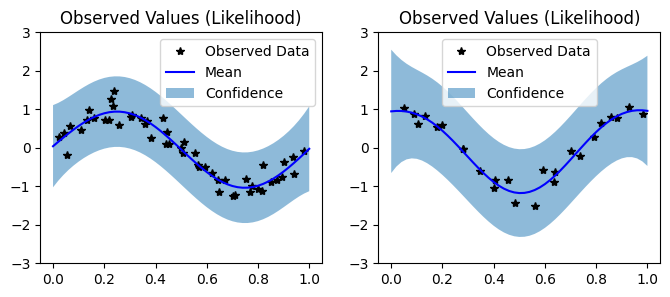

In [7]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, axs = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions (use the same test points)
with torch.no_grad(), qpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    # This contains predictions for both outcomes as a list
    predictions = likelihood(*model(test_x, test_x))
    
for submodel, prediction, ax in zip(model.models, predictions, axs):
    mean = prediction.mean
    lower, upper = prediction.confidence_region(rescale=True)
    
    tr_x = submodel.train_inputs[0].detach().numpy()
    tr_y = submodel.train_targets.detach().numpy()
    
    # Plot training data as black stars
    ax.plot(tr_x, tr_y, 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean.numpy(), 'b')
    # Shade in confidence 
    ax.fill_between(test_x.numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title('Observed Values (Likelihood)')

None